## **HW Final - Series Temporales: TOSCOS**
## Álvaro Payo Bastante

In [3]:
import warnings
warnings.filterwarnings('ignore')

## **1. Importar librerías y datos**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.models import Theta, FourTheta
from darts.models import TBATS
from darts.metrics import mape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode

import sktime
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_correlations

In [5]:
#Importamos la libreria de gráficos Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Análisis predictivo/datos.csv')
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,T1a,5,2015-07-31,11075,915,1,1,0,1
1,T1b,5,2015-07-31,12602,1414,1,1,0,1
2,T1c,5,2015-07-31,5425,453,1,1,0,1
3,T2a,5,2015-07-31,10483,1223,1,1,0,1
4,T2b,5,2015-07-31,6456,595,1,1,0,1
...,...,...,...,...,...,...,...,...,...
9231,T2c,2,2013-01-01,0,0,0,0,a,1
9232,T3a,2,2013-01-01,0,0,0,0,a,1
9233,T3b,2,2013-01-01,0,0,0,0,a,1
9234,T3c,2,2013-01-01,0,0,0,0,a,1


## **2. Análisis exploratorio y valores de cada variable**

### **2.1. Análisis exploratorio**

In [8]:
df.describe()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,9236.000000,9236.000000,9236.000000,9236.000000,9236.000000,9236.000000
mean,3.998159,5793.075682,656.204742,0.809117,0.381767,0.179082
std,1.997480,3730.614003,410.196895,0.393019,0.485846,0.383442
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3709.000000,402.000000,1.000000,0.000000,0.000000
50%,4.000000,5944.000000,715.000000,1.000000,0.000000,0.000000
75%,6.000000,8450.250000,909.000000,1.000000,1.000000,0.000000
max,7.000000,32221.000000,1900.000000,1.000000,1.000000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9236 entries, 0 to 9235
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          9236 non-null   object
 1   DayOfWeek      9236 non-null   int64 
 2   Date           9236 non-null   object
 3   Sales          9236 non-null   int64 
 4   Customers      9236 non-null   int64 
 5   Open           9236 non-null   int64 
 6   Promo          9236 non-null   int64 
 7   StateHoliday   9236 non-null   object
 8   SchoolHoliday  9236 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 649.5+ KB


In [10]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

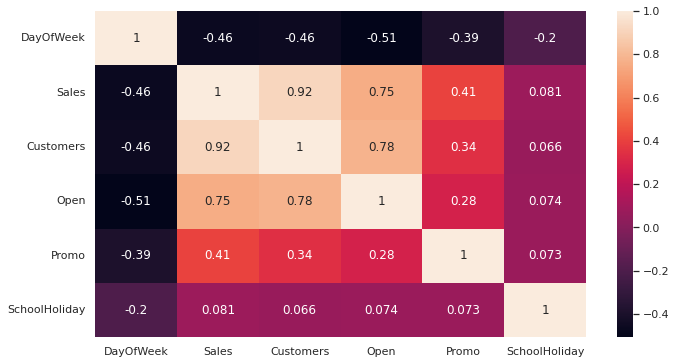

In [11]:
corr_df = df.corr(method = 'pearson')
plt.figure(figsize = (11, 6))
sns.heatmap(corr_df, annot = True)
plt.show()
#Mucha correlación entre las ventas y los clientes (0.92) 
#También hay una correlación considerable entre si la tienda está abierta, las ventas (0.75) y los clientes (0.78)

### **2.2. Valores de cada variable**






In [12]:
df['Store'].value_counts()
#Faltan datos en la tienda 3b

T1a    942
T1b    942
T1c    942
T2a    942
T2b    942
T2c    942
T3a    942
T3c    942
T3d    942
T3b    758
Name: Store, dtype: int64

In [13]:
df['DayOfWeek'].value_counts() #dias de la semana enumerados en orden (1 -> lunes, 2 -> martes...)

5    1324
4    1324
3    1323
2    1323
1    1314
7    1314
6    1314
Name: DayOfWeek, dtype: int64

In [14]:
df['Sales'].value_counts()

0       1765
5680       7
6275       7
9218       6
5449       6
        ... 
3729       1
6210       1
9560       1
9559       1
5298       1
Name: Sales, Length: 5148, dtype: int64

In [15]:
df['Customers'].value_counts() #num de clientes que han entrado en cada tienda

0       1765
871       28
668       28
764       27
780       25
        ... 
1601       1
1516       1
1615       1
1571       1
1419       1
Name: Customers, Length: 1290, dtype: int64

In [16]:
df['Open'].value_counts() #si la tienda esta abierta o no -> 1 si está abierta y 0 si no lo está

1    7473
0    1763
Name: Open, dtype: int64

In [17]:
df['Promo'].value_counts() #si la tienda tiene promociones o no -> 1 si tiene y 0 si no

0    5710
1    3526
Name: Promo, dtype: int64

In [18]:
df['StateHoliday'].value_counts() #si es fiesta o no -> 0 si no es fiesta (a, b, c tengo que investigar a que se refiere)

0    8978
a     160
b      60
c      38
Name: StateHoliday, dtype: int64

In [19]:
df['SchoolHoliday'].value_counts() #si es dia lectivo -> 1 si hay vacaciones y 0 si es lectivo

0    7582
1    1654
Name: SchoolHoliday, dtype: int64

## **3. Limpieza y transformación de variables**

In [20]:
#Eliminación de NAs
df_diario = df.copy()
df_diario = df_diario[df_diario['Sales'] > 0]

In [21]:
#Transformación de la variable 'Date'
df_diario['Date'] = pd.to_datetime(df_diario['Date'])
df_diario = df_diario.sort_values(['Date'])
df_diario = df_diario.set_index('Date')

df_diario.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-02,T3d,3,5298,689,1,0,0,1
2013-01-02,T1a,3,6072,697,1,0,0,1
2013-01-02,T1b,3,6676,1134,1,0,0,1
2013-01-02,T2a,3,9977,1285,1,0,0,1
2013-01-02,T3c,3,6357,767,1,0,0,1


In [22]:
df_diario.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,T2b,5,6456,595,1,1,0,1
2015-07-31,T2a,5,10483,1223,1,1,0,1
2015-07-31,T1c,5,5425,453,1,1,0,1
2015-07-31,T1b,5,12602,1414,1,1,0,1
2015-07-31,T1a,5,11075,915,1,1,0,1


## **4. Ventas diarias de las 10 tiendas**

In [23]:
df_1a = df_diario[df_diario['Store'] == 'T1a']
df_1b = df_diario[df_diario['Store'] == 'T1b']
df_1c = df_diario[df_diario['Store'] == 'T1c']
df_2a = df_diario[df_diario['Store'] == 'T2a']
df_2b = df_diario[df_diario['Store'] == 'T2b']
df_2c = df_diario[df_diario['Store'] == 'T2c']
df_3a = df_diario[df_diario['Store'] == 'T3a']
df_3b = df_diario[df_diario['Store'] == 'T3b']
df_3c = df_diario[df_diario['Store'] == 'T3c']
df_3d = df_diario[df_diario['Store'] == 'T3d']

Text(0.5, 1.0, 'Ventas diarias T1a')

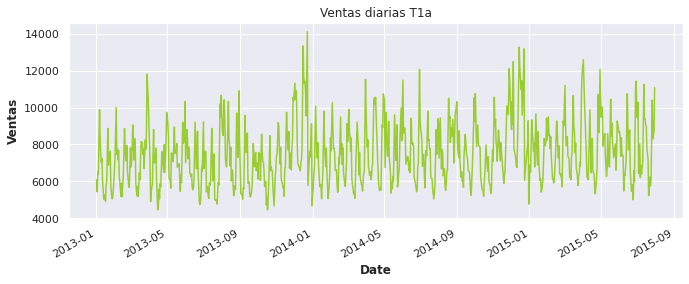

In [24]:
#Ventas T1a
VD1a = df_1a['Sales'].plot(color = 'yellowgreen')
VD1a.set_ylabel('Ventas');
VD1a.set_xlabel('Date');
VD1a.set_title('Ventas diarias T1a')

Text(0.5, 1.0, 'Ventas diarias T1b')

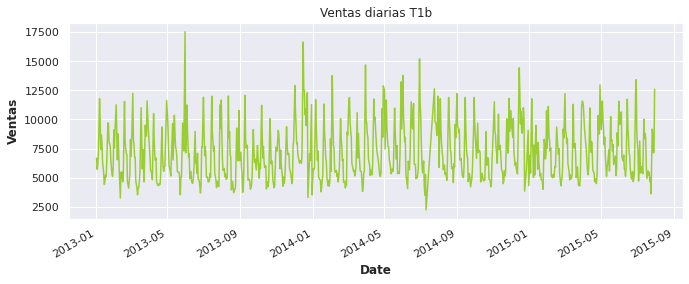

In [25]:
#Ventas T1b
VD1b = df_1b['Sales'].plot(color = 'yellowgreen')
VD1b.set_ylabel('Ventas');
VD1b.set_xlabel('Date');
VD1b.set_title('Ventas diarias T1b')

Text(0.5, 1.0, 'Ventas diarias T1c')

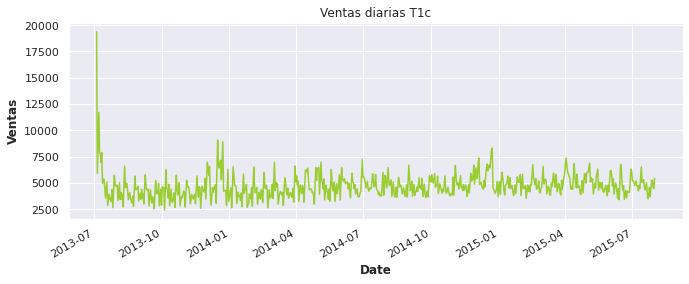

In [26]:
#Ventas T1c
VD1c = df_1c['Sales'].plot(color = 'yellowgreen')
VD1c.set_ylabel('Ventas');
VD1c.set_xlabel('Date');
VD1c.set_title('Ventas diarias T1c')

Text(0.5, 1.0, 'Ventas diarias T2a')

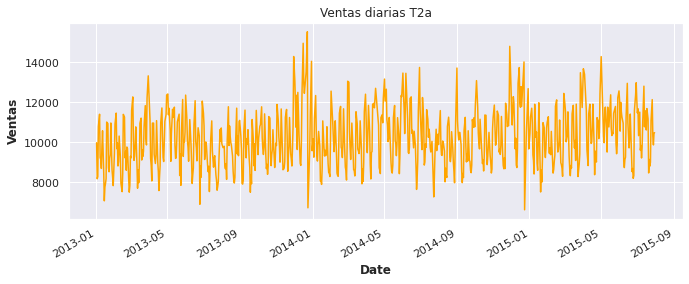

In [27]:
#Ventas T2a
VD2a = df_2a['Sales'].plot(color = 'orange')
VD2a.set_ylabel('Ventas');
VD2a.set_xlabel('Date');
VD2a.set_title('Ventas diarias T2a')

Text(0.5, 1.0, 'Ventas diarias T2b')

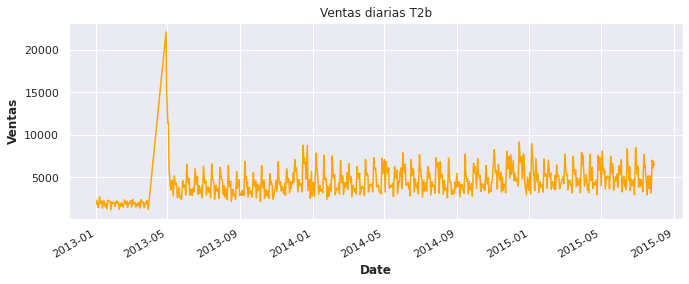

In [28]:
#Ventas T2b
VD2b = df_2b['Sales'].plot(color = 'orange')
VD2b.set_ylabel('Ventas');
VD2b.set_xlabel('Date');
VD2b.set_title('Ventas diarias T2b')

Text(0.5, 1.0, 'Ventas diarias T2c')

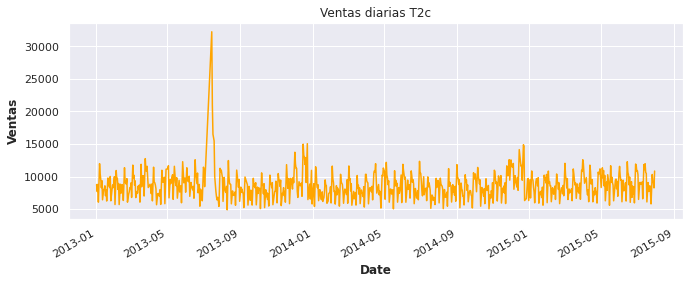

In [29]:
#Ventas T2c
VD2c = df_2c['Sales'].plot(color = 'orange')
VD2c.set_ylabel('Ventas');
VD2c.set_xlabel('Date');
VD2c.set_title('Ventas diarias T2c')

Text(0.5, 1.0, 'Ventas diarias T3a')

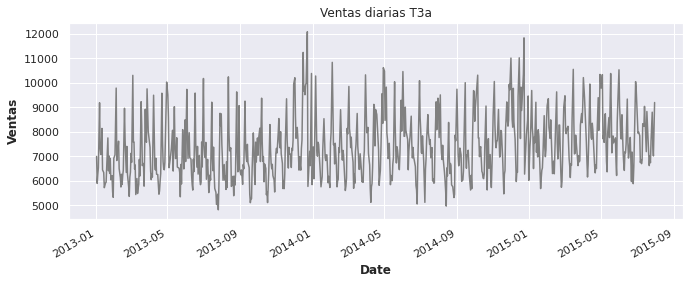

In [30]:
#Ventas T3a
VD3a = df_3a['Sales'].plot(color = 'grey')
VD3a.set_ylabel('Ventas');
VD3a.set_xlabel('Date');
VD3a.set_title('Ventas diarias T3a')

Text(0.5, 1.0, 'Ventas diarias T3b')

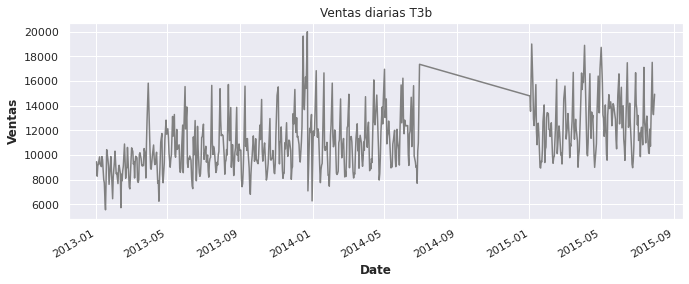

In [31]:
#Ventas T3b
VD3b = df_3b['Sales'].plot(color = 'grey')
VD3b.set_ylabel('Ventas');
VD3b.set_xlabel('Date');
VD3b.set_title('Ventas diarias T3b')

Text(0.5, 1.0, 'Ventas diarias T3c')

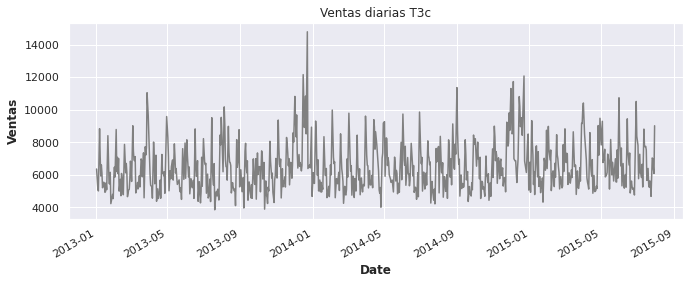

In [32]:
#Ventas T3c
VD3c = df_3c['Sales'].plot(color = 'grey')
VD3c.set_ylabel('Ventas');
VD3c.set_xlabel('Date');
VD3c.set_title('Ventas diarias T3c')

Text(0.5, 1.0, 'Ventas diarias T3d')

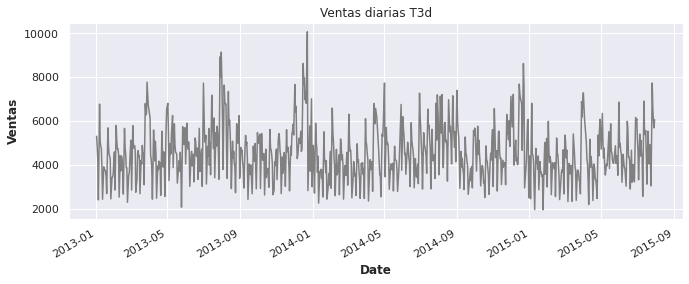

In [33]:
#Ventas T3d
VD3d = df_3d['Sales'].plot(color = 'grey')
VD3d.set_ylabel('Ventas');
VD3d.set_xlabel('Date');
VD3d.set_title('Ventas diarias T3d')

## **5. Ventas diarias de las 3 zonas**

In [34]:
df_zona1 = df_diario[(df_diario['Store'] == 'T1a') | (df_diario['Store'] == 'T1b') | (df_diario['Store'] == 'T1c')]
df_zona2 = df_diario[(df_diario['Store'] == 'T2a') | (df_diario['Store'] == 'T2b') | (df_diario['Store'] == 'T2c')]
df_zona3 = df_diario[(df_diario['Store'] == 'T3a') | (df_diario['Store'] == 'T3b') | (df_diario['Store'] == 'T3c') | (df_diario['Store'] == 'T3d')]

In [35]:
df_zona1_ventas = df_zona1.groupby(by = 'Date').sum()
df_zona2_ventas = df_zona2.groupby(by = 'Date').sum()
df_zona3_ventas = df_zona3.groupby(by = 'Date').sum()

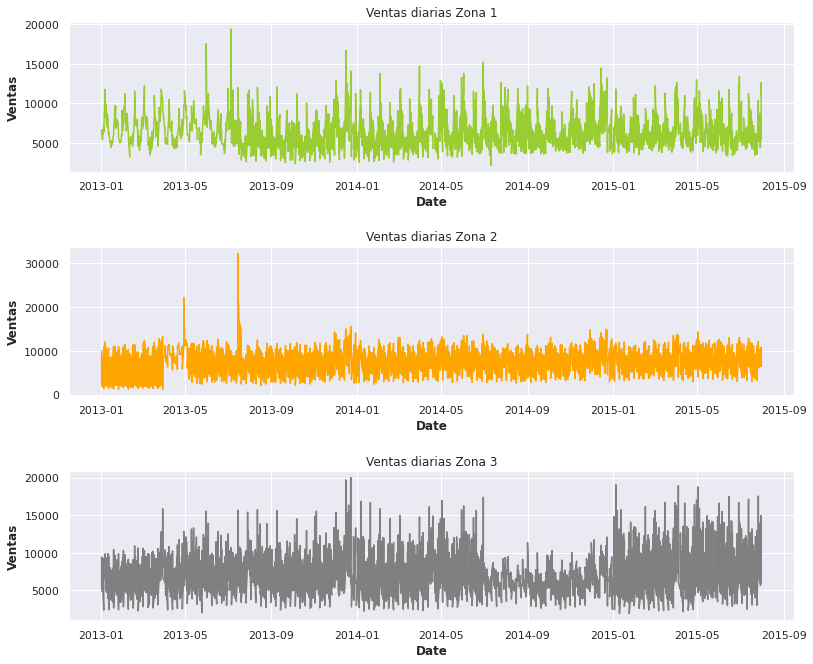

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (13,11))

ax1.plot(df_zona1['Sales'], color = 'yellowgreen')
ax1.set_ylabel('Ventas');
ax1.set_xlabel('Date');
ax1.set_title('Ventas diarias Zona 1')

ax2.plot(df_zona2['Sales'], color = "orange") #cambiar color a mas oscuro y aplicar en el de arriba a las tiendas de la zona 2
ax2.set_ylabel('Ventas');
ax2.set_xlabel('Date');
ax2.set_title('Ventas diarias Zona 2')

ax3.plot(df_zona3['Sales'], color = "grey") #cambiar color y aplicar en el de arriba a las tiendas de la zona 3
ax3.set_ylabel('Ventas');
ax3.set_xlabel('Date');
ax3.set_title('Ventas diarias Zona 3')

plt.subplots_adjust(hspace = 0.5)


## **6. Ventas totales diarias**

In [37]:
Ventas_totales_diarias = df_diario.groupby(by = 'Date').sum()

Text(0.5, 1.0, 'Ventas totales diarias')

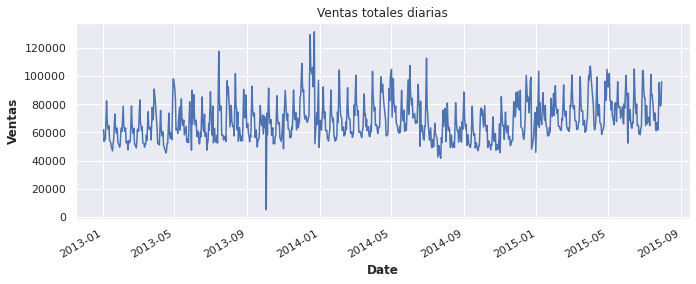

In [38]:
#Ventas totales diarias
VTD = Ventas_totales_diarias['Sales'].plot()
VTD.set_ylabel('Ventas');
VTD.set_title('Ventas totales diarias')

## **7. Ventas totales semanales**

In [39]:
Ventas_totales_semanales = Ventas_totales_diarias.copy()
Ventas_totales_semanales = Ventas_totales_semanales.resample("w").sum()

Text(0.5, 1.0, 'Ventas totales semanales')

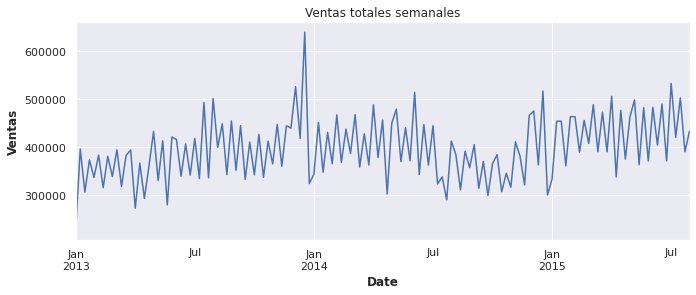

In [40]:
#Ventas totales semanales
VTS = Ventas_totales_semanales['Sales'].plot()
VTS.set_ylabel('Ventas');
VTS.set_title('Ventas totales semanales')

## **8. Predicciones de las ventas totales diarias**

### **8.1. ETS**

In [41]:
Ventas_totales_diarias_pred = Ventas_totales_diarias.copy()
Ventas_totales_diarias_pred = pd.DataFrame(Ventas_totales_diarias_pred['Sales'])
Ventas_totales_diarias_pred.head() 

,Sales
Date,
2013-01-02,61926
2013-01-03,53588
2013-01-04,56578
2013-01-05,54938
2013-01-07,82398


In [42]:
Ventas_totales_diarias_pred.index = pd.PeriodIndex(Ventas_totales_diarias_pred.index, freq="d")

745 40


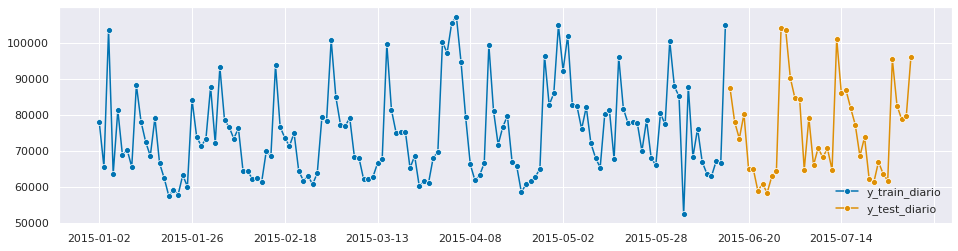

In [43]:
#Divido los datos en train y test. Test son los 40 días
y_train_diario, y_test_diario = temporal_train_test_split(y = Ventas_totales_diarias_pred, test_size = 40)

plot_series(y_train_diario['2015':], y_test_diario, labels=["y_train_diario", "y_test_diario"])
print(y_train_diario.shape[0], y_test_diario.shape[0])

In [44]:
#ETS para ventas totales diarias

#fh_ETS_diario = np.arange(len(y_test_diario)) + 1 
fh_ETS_diario = pd.DataFrame(y_test_diario).index

ETS_model_diario = AutoETS(auto = True, sp = 12, n_jobs = -1)

In [45]:
ETS_model_diario.fit(y_train_diario)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [46]:
print(ETS_model_diario.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  745
Model:                       ETS(MNM)   Log Likelihood               -8007.092
Date:                Wed, 11 Jan 2023   AIC                          16046.185
Time:                        11:04:08   BIC                          16119.999
Sample:                    01-02-2013   HQIC                         16074.636
                         - 06-15-2015   Scale                            0.028
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1909      0.027      6.988      0.000       0.137       0.244
smoothing_seasonal      0.2892      0.026     10.972      0.000       0.238       0.341
initial_level   

In [47]:
ETS_pred_diario = ETS_model_diario.predict(fh_ETS_diario)
ETS_pred_diario

,Sales
2015-06-16,65487.695860
2015-06-17,62737.035694
2015-06-18,69058.345604
2015-06-19,73801.969471
2015-06-20,77516.309819
2015-06-22,86179.677339
2015-06-23,81486.583287
2015-06-24,67475.616301
2015-06-25,75466.295317
2015-06-26,67509.456050


In [48]:
Comparacion_ETS_diario = pd.DataFrame()

Comparacion_ETS_diario['Datos reales'] = y_test_diario['Sales']
Comparacion_ETS_diario['Predicciones'] = ETS_pred_diario['Sales']

Comparacion_ETS_diario.head()

,Datos reales,Predicciones
2015-06-16,87386,65487.695860
2015-06-17,78024,62737.035694
2015-06-18,73415,69058.345604
2015-06-19,80181,73801.969471
2015-06-20,64920,77516.309819


In [49]:
Comparacion_ETS_diario.tail()

,Datos reales,Predicciones
2015-07-27,95402,93021.984160
2015-07-28,82582,86179.677339
2015-07-29,78795,81486.583287
2015-07-30,79610,67475.616301
2015-07-31,96078,75466.295317


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot: >)

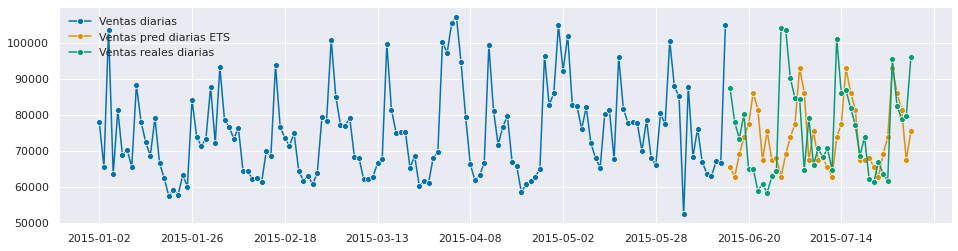

In [50]:
plot_series(y_train_diario['2015':], ETS_pred_diario, y_test_diario, labels=["Ventas diarias", "Ventas pred diarias ETS", "Ventas reales diarias"])

In [51]:
#1. Mean Absolute Percentage Error (MAPE)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

MAPE_ETS_diario = mean_absolute_percentage_error(y_test_diario, ETS_pred_diario[0:40])*100
MAPE_ETS_diario

13.779662510303847

In [52]:
#2. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
MSE_ETS_diario = mse(y_test_diario, ETS_pred_diario[0:40])
MSE_ETS_diario

201334618.33773598

In [53]:
#3. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
RMSE_ETS_diario = rmse(y_test_diario, ETS_pred_diario[0:40])
RMSE_ETS_diario

14189.243050203066

### **8.2. ARIMA**

In [54]:
#Transformación de los datos a logaritmos.
transformer = LogTransformer()
log_df_diario = transformer.fit_transform(Ventas_totales_diarias_pred)
log_df_diario.tail()

,Sales
Date,
2015-07-27,11.465855
2015-07-28,11.321547
2015-07-29,11.274605
2015-07-30,11.284895
2015-07-31,11.472916


Text(0.5, 1.0, 'Ventas totales diarias: Transformación LOG')

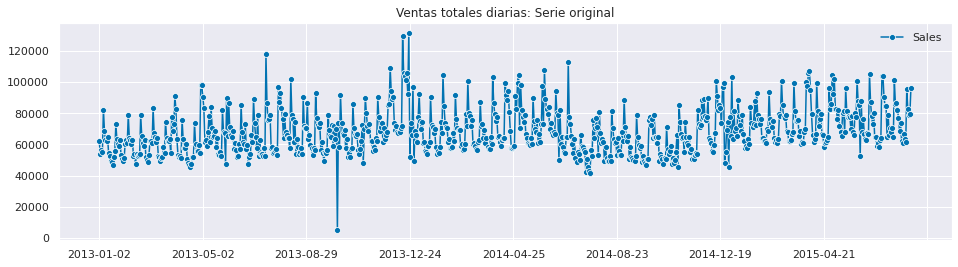

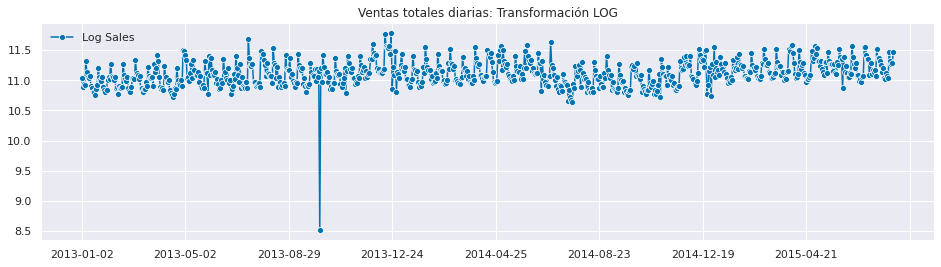

In [55]:
#Comparación gráfico con datos originales vs gráfico con datos transformados a logaritmos.
fig, ax = plot_series(Ventas_totales_diarias_pred, labels = ["Sales"])
ax.set_title('Ventas totales diarias: Serie original')
fig, ax = plot_series(log_df_diario, labels = ["Log Sales"])
ax.set_title('Ventas totales diarias: Transformación LOG')

745 40


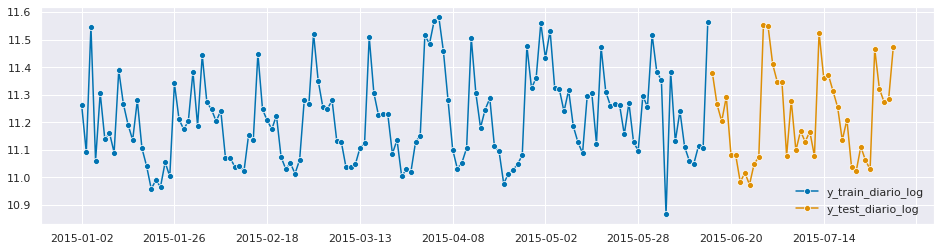

In [56]:
#Divido los datos logarítmicos en train y test. Test son las últimas 6 semanas.
y_train_diario_log, y_test_diario_log = temporal_train_test_split(y = log_df_diario, test_size = 40)

plot_series(y_train_diario_log['2015':], y_test_diario_log, labels=["y_train_diario_log", "y_test_diario_log"])
print(y_train_diario_log.shape[0], y_test_diario_log.shape[0])

In [57]:
#fh_ARIMA_diario_log = np.arange(len(y_test_diario_log)) + 1
fh_ARIMA_diario_log = pd.DataFrame(y_test_diario_log).index

ARIMA_model_diario = AutoARIMA(sp = 7,suppress_warnings = True)

In [58]:
ARIMA_model_diario.fit(y_train_diario_log)

AutoARIMA(sp=7, suppress_warnings=True)

In [59]:
print(ARIMA_model_diario.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  745
Model:               SARIMAX(5, 1, 5)   Log Likelihood                 235.618
Date:                Wed, 11 Jan 2023   AIC                           -449.236
Time:                        11:11:58   BIC                           -398.504
Sample:                    01-02-2013   HQIC                          -429.680
                         - 06-15-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2254      2.126      0.106      0.916      -3.941       4.392
ar.L2          1.1101      1.911      0.581      0.561      -2.635       4.855
ar.L3         -0.6066      1.127     -0.538      0.5

In [60]:
ARIMA_pred_diario_log = ARIMA_model_diario.predict(fh_ARIMA_diario_log)

In [61]:
ARIMA_pred_diario = np.exp(ARIMA_pred_diario_log)
ARIMA_pred_diario

,Sales
2015-06-16,81065.379006
2015-06-17,86891.277766
2015-06-18,78482.081434
2015-06-19,81982.966018
2015-06-20,72774.918045
2015-06-22,68211.453824
2015-06-23,72019.612190
2015-06-24,68804.169836
2015-06-25,74817.333625
2015-06-26,73800.974895


In [62]:
Comparacion_ARIMA_diario = pd.DataFrame()

Comparacion_ARIMA_diario['Datos reales'] = y_test_diario['Sales']
Comparacion_ARIMA_diario['Predicciones'] = ARIMA_pred_diario['Sales']

Comparacion_ARIMA_diario.head()

,Datos reales,Predicciones
2015-06-16,87386,81065.379006
2015-06-17,78024,86891.277766
2015-06-18,73415,78482.081434
2015-06-19,80181,81982.966018
2015-06-20,64920,72774.918045


In [63]:
Comparacion_ARIMA_diario.tail()

,Datos reales,Predicciones
2015-07-27,95402,74987.176625
2015-07-28,82582,73649.596306
2015-07-29,78795,73596.579088
2015-07-30,79610,73419.318889
2015-07-31,96078,74426.111145


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot: >)

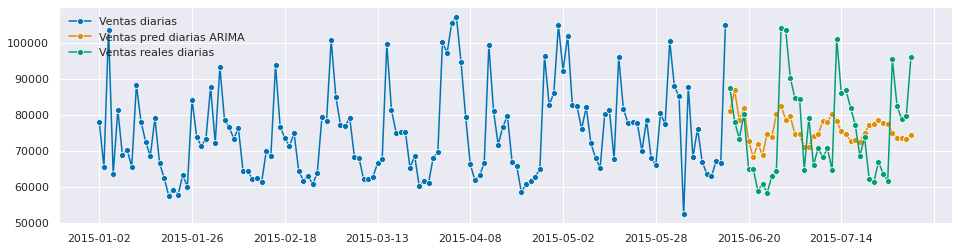

In [64]:
plot_series(y_train_diario['2015':], ARIMA_pred_diario, y_test_diario, labels=["Ventas diarias", "Ventas pred diarias ARIMA", "Ventas reales diarias"])

In [65]:
#1. Mean Absolute Percentage Error (MAPE)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

MAPE_ARIMA_diario = mean_absolute_percentage_error(y_test_diario, ARIMA_pred_diario[0:40])*100
MAPE_ARIMA_diario

14.37071211148977

In [66]:
#2. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
MSE_ARIMA_diario = mse(y_test_diario, ARIMA_pred_diario[0:40])
MSE_ARIMA_diario

151912694.63899332

In [67]:
#3. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
RMSE_ARIMA_diario = rmse(y_test_diario, ARIMA_pred_diario[0:40])
RMSE_ARIMA_diario

12325.286797433693

### **8.3. 4THETA**

In [68]:
Ventas_totales_diarias_pred2 = Ventas_totales_diarias_pred.copy()
Ventas_totales_diarias_pred2['Date'] = Ventas_totales_diarias_pred2.index.to_timestamp()

In [69]:
Ventas_totales_diarias_series = TimeSeries.from_dataframe(Ventas_totales_diarias_pred2, 'Date', 'Sales', fill_missing_dates = True, freq='D', 
                                                          fillna_value  = Ventas_totales_diarias_pred2['Sales'].mean())
Ventas_totales_diarias_series

<TimeSeries (DataArray) (Date: 941, component: 1, sample: 1)>
array([[[ 61926.        ]],

       [[ 53588.        ]],

       [[ 56578.        ]],

       [[ 54938.        ]],

       [[ 68159.04076433]],

       [[ 82398.        ]],

       [[ 68766.        ]],

       [[ 62671.        ]],

       [[ 62306.        ]],

       [[ 64696.        ]],

...

       [[ 61235.        ]],

       [[ 66935.        ]],

       [[ 63699.        ]],

       [[ 61679.        ]],

       [[ 68159.04076433]],

       [[ 95402.        ]],

       [[ 82582.        ]],

       [[ 78795.        ]],

       [[ 79610.        ]],

       [[ 96078.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2013-01-02 2013-01-03 ... 2015-07-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

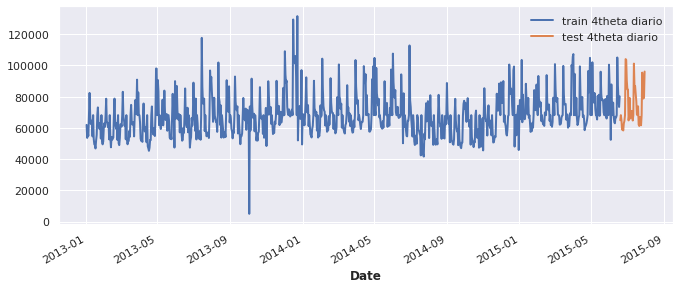

In [70]:
train_4theta_diario, test_4theta_diario = Ventas_totales_diarias_series.split_before(pd.Timestamp("2015-06-20")) 
train_4theta_diario.plot(label="train 4theta diario")
test_4theta_diario.plot(label="test 4theta diario")

In [71]:
fourtheta_model_diario = FourTheta(seasonality_period = 7)
fourtheta_model_diario.fit(train_4theta_diario)
fourtheta_pred_diario = fourtheta_model_diario.predict(len(test_4theta_diario))
print("model {} obtains MAPE: {:.2f}%".format(fourtheta_model_diario, mape(test_4theta_diario, fourtheta_pred_diario)))

model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 15.82%


In [72]:
fourtheta_pred_diario

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 1)>
array([[[72055.67980198]],

       [[80978.67259055]],

       [[91282.5383481 ]],

       [[79588.06803359]],

       [[76563.53296272]],

       [[74979.32297458]],

       [[80692.0486012 ]],

       [[72087.00109454]],

       [[81013.87035999]],

       [[91322.21227884]],

...

       [[76696.6230017 ]],

       [[75109.65109756]],

       [[80832.29780612]],

       [[72212.28626481]],

       [[81154.66143775]],

       [[91480.90800181]],

       [[79761.01323844]],

       [[76729.89551144]],

       [[75142.2331283 ]],

       [[80867.36010735]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-06-20 2015-06-21 ... 2015-07-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [73]:
Comparacion_4theta_diario = pd.DataFrame()

Comparacion_4theta_diario['Datos reales'] = y_test_diario['Sales'].head()
Comparacion_4theta_diario['Predicciones'] = ['72055.67980198', '80978.67259055', '91282.5383481', '79588.06803359', '76563.53296272']

Comparacion_4theta_diario.head()

,Datos reales,Predicciones
2015-06-16,87386,72055.67980198
2015-06-17,78024,80978.67259055
2015-06-18,73415,91282.5383481
2015-06-19,80181,79588.06803359
2015-06-20,64920,76563.53296272


In [74]:
Comparacion_4theta_diario2 = pd.DataFrame()

Comparacion_4theta_diario2['Datos reales'] = y_test_diario['Sales'].tail()
Comparacion_4theta_diario2['Predicciones'] = ['91480.90800181', '79761.01323844', '76729.89551144', '75142.2331283', '80867.36010735']

Comparacion_4theta_diario2.head()

,Datos reales,Predicciones
2015-07-27,95402,91480.90800181
2015-07-28,82582,79761.01323844
2015-07-29,78795,76729.89551144
2015-07-30,79610,75142.2331283
2015-07-31,96078,80867.36010735


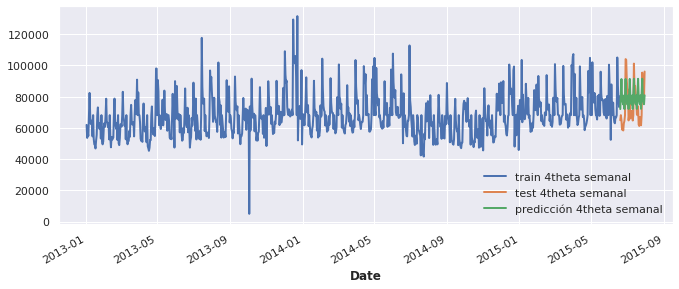

In [75]:
train_4theta_diario.plot(label="train 4theta semanal")
test_4theta_diario.plot(label="test 4theta semanal")
fourtheta_pred_diario.plot(label="predicción 4theta semanal")

In [76]:
MAPE_foutheta_diario = mape(test_4theta_diario, fourtheta_pred_diario)
MAPE_foutheta_diario

15.818260963798657

### **8.4. TBATS**

In [77]:
Ventas_totales_diarias_series

<TimeSeries (DataArray) (Date: 941, component: 1, sample: 1)>
array([[[ 61926.        ]],

       [[ 53588.        ]],

       [[ 56578.        ]],

       [[ 54938.        ]],

       [[ 68159.04076433]],

       [[ 82398.        ]],

       [[ 68766.        ]],

       [[ 62671.        ]],

       [[ 62306.        ]],

       [[ 64696.        ]],

...

       [[ 61235.        ]],

       [[ 66935.        ]],

       [[ 63699.        ]],

       [[ 61679.        ]],

       [[ 68159.04076433]],

       [[ 95402.        ]],

       [[ 82582.        ]],

       [[ 78795.        ]],

       [[ 79610.        ]],

       [[ 96078.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2013-01-02 2013-01-03 ... 2015-07-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

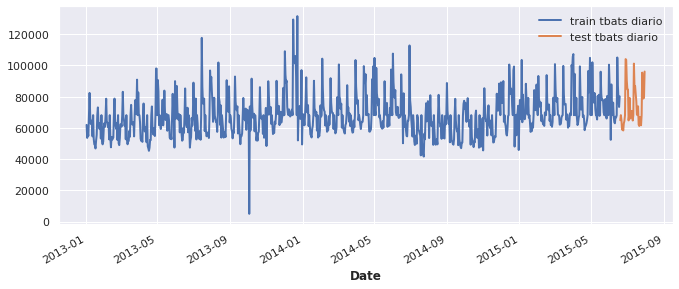

In [78]:
train_tbats_diario, test_tbats_diario = Ventas_totales_diarias_series.split_before(pd.Timestamp("2015-06-20")) 
train_tbats_diario.plot(label="train tbats diario")
test_tbats_diario.plot(label="test tbats diario")

In [79]:
model_TBATS_diario = TBATS(
use_box_cox = None,
box_cox_bounds = (0, 1),
use_trend = None,
use_damped_trend = None,
seasonal_periods = "freq",
use_arma_errors = True,
show_warnings = False,
multiprocessing_start_method = 'spawn',
random_state = 0)
model_TBATS_diario.fit(train_tbats_diario)
TBATS_pred_diario = model_TBATS_diario.predict(len(test_tbats_diario))
print("model {} obtains MAPE: {:.2f}%".format(model_TBATS_diario, mape(test_tbats_diario, TBATS_pred_diario)))

model (T)BATS obtains MAPE: 12.93%


In [80]:
model_TBATS_diario.model.params.summary()

'Use Box-Cox: False\nUse trend: False\nUse damped trend: False\nSeasonal periods: [7.]\nSeasonal harmonics [3]\nARMA errors (p, q): (3, 5)\nSmoothing (Alpha): 0.887494\nSeasonal Parameters (Gamma): [-5.24561182e-05  2.68216057e-05]\nAR coefficients [2.68216057e-05 3.50045513e-01 1.13477944e-01]\nMA coefficients [-0.53200972 -0.28432705 -0.01750204 -0.13383624 -0.00600418]\nSeed vector [61270.61782995  -462.30731949 -4530.95596998  2676.81114697\n -4392.10977336  1532.36311387  -196.34450128     0.\n     0.             0.             0.             0.\n     0.             0.             0.        ]\n'

In [81]:
TBATS_pred_diario

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 1)>
array([[[69415.98610198]],

       [[76275.5541135 ]],

       [[86459.27586782]],

       [[75378.89780258]],

       [[72724.90399334]],

       [[71036.79148996]],

       [[75726.63766145]],

       [[68265.72743158]],

       [[74792.90523425]],

       [[85103.35771267]],

...

       [[72025.59693092]],

       [[70623.25365161]],

       [[75401.90171575]],

       [[68041.6057293 ]],

       [[74632.29943867]],

       [[84988.05024132]],

       [[74674.42094973]],

       [[72025.55272755]],

       [[70623.2221118 ]],

       [[75401.87921159]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-06-20 2015-06-21 ... 2015-07-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [82]:
Comparacion_TBATS_diario = pd.DataFrame()

Comparacion_TBATS_diario['Datos reales'] = y_test_diario['Sales'].head()
Comparacion_TBATS_diario['Predicciones'] = ['69415.98610198', '76275.5541135', '86459.27586782', '75378.89780258', '429643.26']

Comparacion_TBATS_diario.head()

,Datos reales,Predicciones
2015-06-16,87386,69415.98610198
2015-06-17,78024,76275.5541135
2015-06-18,73415,86459.27586782
2015-06-19,80181,75378.89780258
2015-06-20,64920,429643.26


In [83]:
Comparacion_TBATS_diario2 = pd.DataFrame()

Comparacion_TBATS_diario2['Datos reales'] = y_test_diario['Sales'].tail()
Comparacion_TBATS_diario2['Predicciones'] = ['84988.05024132', '74674.42094973', '72025.55272755', '70623.2221118', '75401.87921159']

Comparacion_TBATS_diario2.head()

,Datos reales,Predicciones
2015-07-27,95402,84988.05024132
2015-07-28,82582,74674.42094973
2015-07-29,78795,72025.55272755
2015-07-30,79610,70623.2221118
2015-07-31,96078,75401.87921159


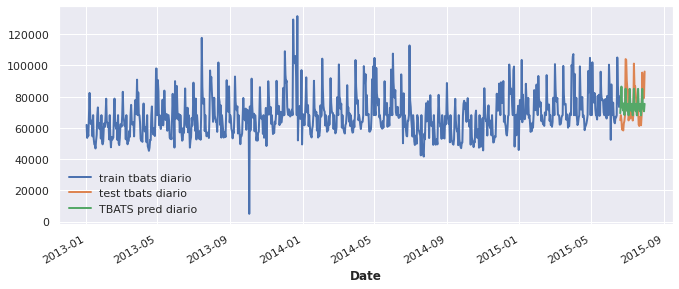

In [84]:
train_tbats_diario.plot(label="train tbats diario")
test_tbats_diario.plot(label="test tbats diario")
TBATS_pred_diario.plot(label="TBATS pred diario")

In [85]:
MAPE_TBATS_diario = mape(test_tbats_diario, TBATS_pred_diario)
MAPE_TBATS_diario

12.932973352956173

### **8.5. Comparación modelos diarios**

In [86]:
MAPE_modelos_diarios = pd.DataFrame()

MAPE_modelos_diarios['Modelos diarios'] = ["ETS", "ARIMA", "4THETA", "TBATS"]
MAPE_modelos_diarios['MAPE (%)'] = [MAPE_ETS_diario, MAPE_ARIMA_diario, MAPE_foutheta_diario, MAPE_TBATS_diario]
MAPE_modelos_diarios.set_index('Modelos diarios', inplace = True)
MAPE_modelos_diarios = MAPE_modelos_diarios.sort_values(by = "MAPE (%)", ascending = True)

MAPE_modelos_diarios.round(3)

,MAPE (%)
Modelos diarios,
TBATS,12.933
ETS,13.780
ARIMA,14.371
4THETA,15.818


### **8.6. Predicción de las ventas totales diarias desde el 01.08.2015 hasta el 10.09.2015 con TBATS**

In [87]:
model_TBATS_def = TBATS(
use_box_cox = None,
box_cox_bounds = (0, 1),
use_trend = None,
use_damped_trend = None,
seasonal_periods = "freq",
use_arma_errors = True,
show_warnings = False,
multiprocessing_start_method = 'spawn',
random_state = 0)
model_TBATS_def.fit(Ventas_totales_diarias_series)

In [88]:
TBATS_pred_def = model_TBATS_def.predict(40)
TBATS_pred_def

<TimeSeries (DataArray) (Date: 40, component: 1, sample: 1)>
array([[[77475.30084718]],

       [[84044.60850162]],

       [[90905.2385191 ]],

       [[77748.89385659]],

       [[74460.57296976]],

       [[71520.32827136]],

       [[76245.28318902]],

       [[68859.42244868]],

       [[75113.78338008]],

       [[86199.46807573]],

...

       [[86243.51643256]],

       [[75947.09761765]],

       [[73336.55282665]],

       [[71929.80054599]],

       [[76609.00860769]],

       [[69090.5367772 ]],

       [[75533.21204547]],

       [[86243.36231955]],

       [[75946.93402013]],

       [[73336.82037005]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-08-01 2015-08-02 ... 2015-09-09
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [89]:
TBATS_diario_def = pd.DataFrame()

TBATS_diario_def['Fechas'] = ['2015-08-01','2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05' ]
TBATS_diario_def['Predicciones'] = ['77475.30084718', '84044.60850162', '90905.2385191 ', '77748.89385659', '74460.57296976']
TBATS_diario_def.set_index('Fechas', inplace = True)

TBATS_diario_def

,Predicciones
Fechas,
2015-08-01,77475.30084718
2015-08-02,84044.60850162
2015-08-03,90905.2385191
2015-08-04,77748.89385659
2015-08-05,74460.57296976


In [90]:
TBATS_diario_def2 = pd.DataFrame()

TBATS_diario_def2['Fechas'] = ['2015-09-06','2015-09-07', '2015-09-08', '2015-09-09', '2015-09-10' ]
TBATS_diario_def2['Predicciones'] = ['69090.5367772', '75533.21204547', '86243.36231955', '75946.93402013', '73336.82037005']
TBATS_diario_def2.set_index('Fechas', inplace = True)

TBATS_diario_def2

,Predicciones
Fechas,
2015-09-06,69090.5367772
2015-09-07,75533.21204547
2015-09-08,86243.36231955
2015-09-09,75946.93402013
2015-09-10,73336.82037005


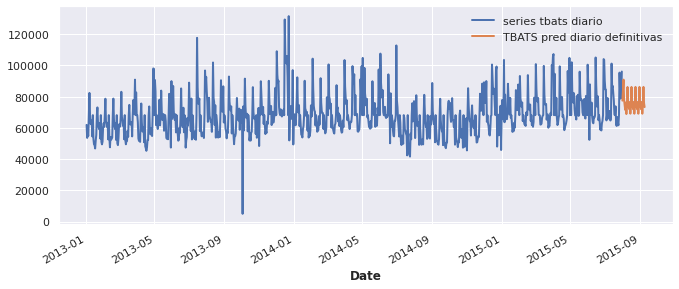

In [91]:
Ventas_totales_diarias_series.plot(label="series tbats diario")
TBATS_pred_def.plot(label="TBATS pred diario definitivas")

In [ ]:
TBATS_pred_def.to_csv('/content/drive/MyDrive/Análisis predictivo/Predicciones_diarias.csv', index=False)

## **9. Predicciones de las ventas totales semanales**

### **9.1. ETS**

In [92]:
Ventas_totales_semanales_pred = Ventas_totales_semanales.copy()
Ventas_totales_semanales_pred = pd.DataFrame(Ventas_totales_semanales_pred['Sales'])
Ventas_totales_semanales_pred.head() 

,Sales
Date,
2013-01-06,227030
2013-01-13,395390
2013-01-20,305576
2013-01-27,372581
2013-02-03,335998


129 6


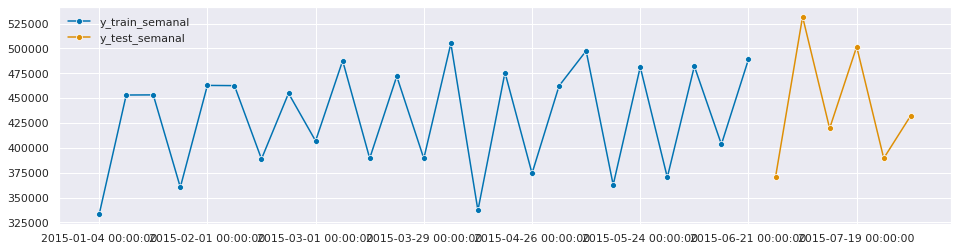

In [93]:
#Divido los datos en train y test. Test son las últimas 5 semanas.
y_train_semanal, y_test_semanal = temporal_train_test_split(y = Ventas_totales_semanales_pred, test_size=6)

plot_series(y_train_semanal['2015':], y_test_semanal, labels=["y_train_semanal", "y_test_semanal"])
print(y_train_semanal.shape[0], y_test_semanal.shape[0])

In [94]:
fh_ETS_semanal = np.arange(len(y_test_semanal)) + 1

ETS_model_semanal = AutoETS(auto = True, sp = 52, n_jobs = -1) 

In [95]:
ETS_model_semanal.fit(y_train_semanal)

AutoETS(auto=True, n_jobs=-1, sp=52)

In [96]:
print(ETS_model_semanal.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  129
Model:                       ETS(MNM)   Log Likelihood               -1554.055
Date:                Wed, 11 Jan 2023   AIC                           3220.109
Time:                        11:33:18   BIC                           3380.259
Sample:                    01-06-2013   HQIC                          3285.181
                         - 06-21-2015   Scale                            0.011
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1727      0.053      3.230      0.001       0.068       0.278
smoothing_seasonal   8.273e-05        nan        nan        nan         nan         nan
initial_level   

In [97]:
#Auto ETS Forecasting
ETS_pred_semanal = ETS_model_semanal.predict(fh_ETS_semanal)
ETS_pred_semanal

,Sales
2015-06-28,384074.262364
2015-07-05,468795.273317
2015-07-12,357510.027115
2015-07-19,471325.490140
2015-07-26,341081.264391
2015-08-02,497236.455630


In [137]:
Comparacion_ETS_semanal = pd.DataFrame()

Comparacion_ETS_semanal['Datos reales'] = y_test_semanal['Sales']
Comparacion_ETS_semanal['Predicciones'] = ETS_pred_semanal['Sales']

Comparacion_ETS_semanal

,Datos reales,Predicciones
2015-06-28,370530,384074.262364
2015-07-05,531819,468795.273317
2015-07-12,419561,357510.027115
2015-07-19,501709,471325.490140
2015-07-26,389502,341081.264391
2015-08-02,432467,497236.455630


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot: >)

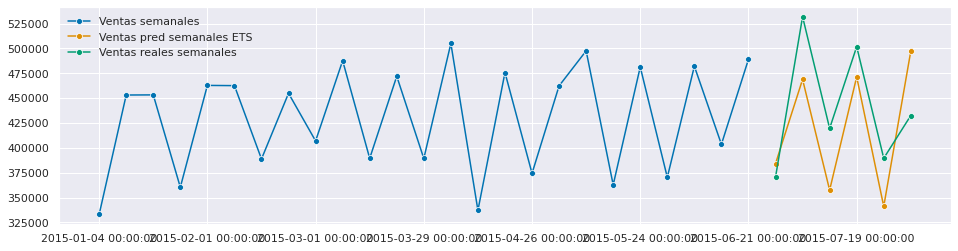

In [101]:
plot_series(y_train_semanal['2015':], ETS_pred_semanal, y_test_semanal, labels=["Ventas semanales", "Ventas pred semanales ETS", "Ventas reales semanales"])

In [102]:
ETS_pred_semanal_ints = ETS_model_semanal.predict_interval(fh_ETS_semanal, coverage=0.9)
ETS_pred_semanal_ints

Coverage               
                      0.9               
                    lower          upper
2015-06-28  317730.128931  451513.981966
2015-07-05  388778.384345  550909.598911
2015-07-12  295970.686882  417278.808389
2015-07-19  388271.363996  559153.824127
2015-07-26  280904.885401  403525.424060
2015-08-02  404029.732002  589243.944237

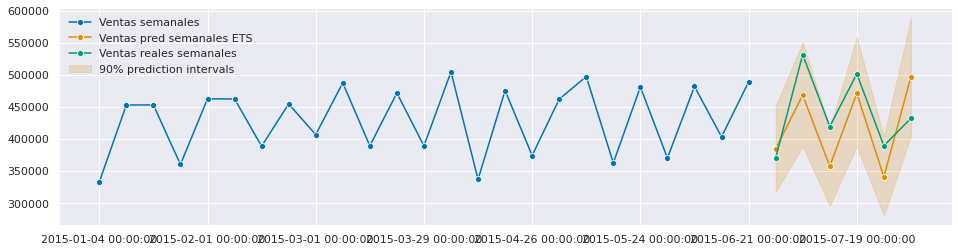

In [103]:
fig, ax = plot_series(y_train_semanal['2015':], ETS_pred_semanal, y_test_semanal, labels=["Ventas semanales", "Ventas pred semanales ETS", "Ventas reales semanales"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ETS_pred_semanal_ints[('Coverage', 0.9, 'lower')],
    ETS_pred_semanal_ints[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

In [104]:
#1. Mean Absolute Percentage Error (MAPE)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

MAPE_ETS_semanal = mean_absolute_percentage_error(y_test_semanal, ETS_pred_semanal[0:6])*100
MAPE_ETS_semanal

10.626610221092564

In [105]:
#2. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
MSE_ETS_semanal = mse(y_test_semanal, ETS_pred_semanal[0:6])
MSE_ETS_semanal

2578094682.472901

In [106]:
#3. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
RMSE_ETS_semanal = rmse(y_test_semanal, ETS_pred_semanal[0:6])
RMSE_ETS_semanal

50774.94148172798

###**9.2. ARIMA**

In [107]:
#Transformación de los datos a logaritmos.
transformer = LogTransformer()
log_df_semanal = transformer.fit_transform(Ventas_totales_semanales_pred)
log_df_semanal.tail()

,Sales
Date,
2015-07-05,13.184058
2015-07-12,12.946964
2015-07-19,13.125776
2015-07-26,12.872624
2015-08-02,12.977261


Text(0.5, 1.0, 'Ventas totales semanales: Transformación LOG')

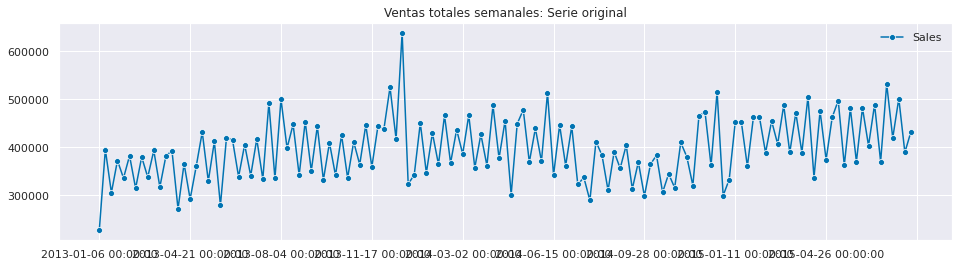

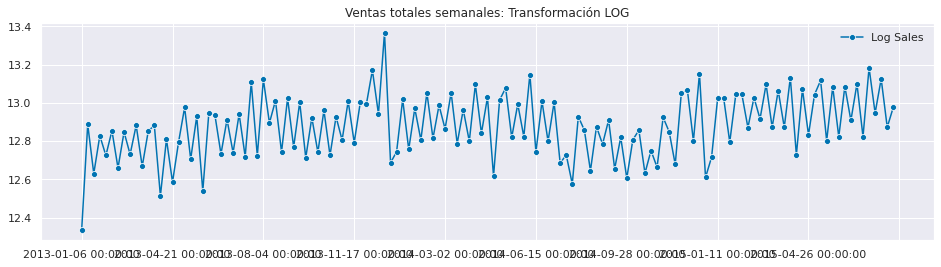

In [108]:
#Comparación gráfico con datos originales vs gráfico con datos transformados a logaritmos.
fig, ax = plot_series(Ventas_totales_semanales_pred, labels = ["Sales"])
ax.set_title('Ventas totales semanales: Serie original')
fig, ax = plot_series(log_df_semanal, labels = ["Log Sales"])
ax.set_title('Ventas totales semanales: Transformación LOG')

129 6


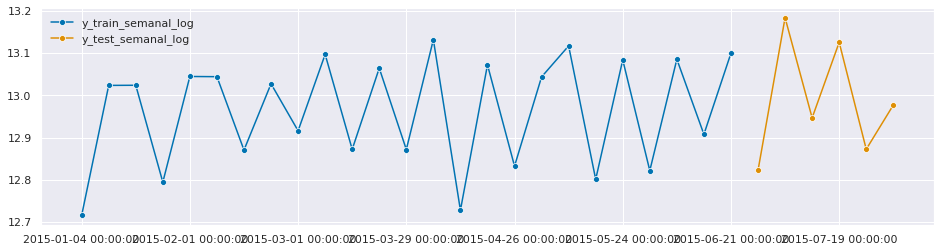

In [109]:
#Divido los datos logarítmicos en train y test. Test son las últimas 6 semanas.
y_train_semanal_log, y_test_semanal_log = temporal_train_test_split(y = log_df_semanal, test_size = 6)

plot_series(y_train_semanal_log['2015':], y_test_semanal_log, labels=["y_train_semanal_log", "y_test_semanal_log"])
print(y_train_semanal_log.shape[0], y_test_semanal_log.shape[0])

In [110]:
fh_ARIMA_semanal_log = np.arange(len(y_test_semanal_log)) + 1

ARIMA_model_semanal = AutoARIMA(sp = 52,suppress_warnings = True)

In [111]:
ARIMA_model_semanal.fit(y_train_semanal_log)

AutoARIMA(sp=52, suppress_warnings=True)

In [112]:
print(ARIMA_model_semanal.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  129
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood                  75.072
Date:                             Wed, 11 Jan 2023   AIC                           -142.143
Time:                                     11:43:04   BIC                           -130.735
Sample:                                 01-06-2013   HQIC                          -137.508
                                      - 06-21-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5557      0.076     -7.344      0.000      -0.704      -0.407
ma.L1         -0.6654      

In [113]:
ARIMA_pred_semanal_log = ARIMA_model_semanal.predict(fh_ARIMA_semanal_log)
ARIMA_pred_semanal_log

,Sales
2015-06-28,12.891972
2015-07-05,13.046852
2015-07-12,12.868444
2015-07-19,12.907904
2015-07-26,12.828474
2015-08-02,12.992828


In [114]:
ARIMA_pred_semanal = np.exp(ARIMA_pred_semanal_log)
ARIMA_pred_semanal

,Sales
2015-06-28,397111.192086
2015-07-05,463634.584281
2015-07-12,387877.046924
2015-07-19,403488.638193
2015-07-26,372679.360500
2015-08-02,439251.582350


In [136]:
Comparacion_ARIMA_semanal = pd.DataFrame()

Comparacion_ARIMA_semanal['Datos reales'] = y_test_semanal['Sales']
Comparacion_ARIMA_semanal['Predicciones'] = ARIMA_pred_semanal['Sales']

Comparacion_ARIMA_semanal

,Datos reales,Predicciones
2015-06-28,370530,397111.192086
2015-07-05,531819,463634.584281
2015-07-12,419561,387877.046924
2015-07-19,501709,403488.638193
2015-07-26,389502,372679.360500
2015-08-02,432467,439251.582350


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot: >)

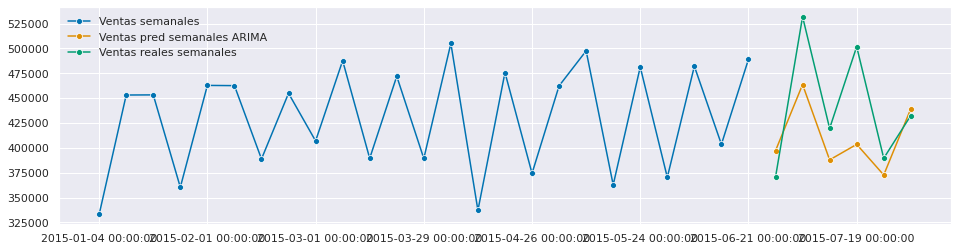

In [117]:
plot_series(y_train_semanal['2015':], ARIMA_pred_semanal, y_test_semanal, labels=["Ventas semanales", "Ventas pred semanales ARIMA", "Ventas reales semanales"])

In [118]:
ARIMA_pred_semanal_log_ints = ARIMA_model_semanal.predict_interval(fh_ARIMA_semanal_log, coverage=0.9) 
ARIMA_pred_semanal_log_ints

Coverage           
                  0.9           
                lower      upper
2015-06-28  12.681799  13.102144
2015-07-05  12.831601  13.262103
2015-07-12  12.632694  13.104194
2015-07-19  12.671550  13.144258
2015-07-26  12.584391  13.072557
2015-08-02  12.746037  13.239618

In [119]:
ARIMA_pred_semanal_ints = np.exp(ARIMA_pred_semanal_log_ints)
ARIMA_pred_semanal_ints

Coverage               
                      0.9               
                    lower          upper
2015-06-28  321836.491987  489991.976692
2015-07-05  373846.682127  574987.121775
2015-07-12  306414.348755  490997.253038
2015-07-19  318554.714379  511067.875634
2015-07-26  291965.407980  475706.717118
2015-08-02  343189.146178  562202.956433

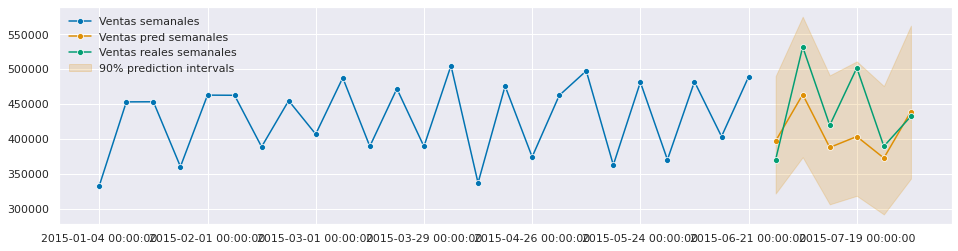

In [120]:
fig, ax = plot_series(y_train_semanal['2015':], ARIMA_pred_semanal, y_test_semanal, labels=["Ventas semanales", "Ventas pred semanales", "Ventas reales semanales"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    np.exp(ARIMA_pred_semanal_log_ints)[('Coverage', 0.9, 'lower')],
    np.exp(ARIMA_pred_semanal_log_ints)[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

In [121]:
#1. Mean Absolute Percentage Error (MAPE)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

MAPE_ARIMA_semanal = mean_absolute_percentage_error(y_test_semanal, ARIMA_pred_semanal[0:6])*100
MAPE_ARIMA_semanal

8.835247064038263

In [122]:
#2. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
MSE_ARIMA_semanal = mse(y_test_semanal, ARIMA_pred_semanal[0:6])
MSE_ARIMA_semanal

2722636405.5157113

In [123]:
#3. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
RMSE_ARIMA_semanal = rmse(y_test_semanal, ARIMA_pred_semanal[0:6])
RMSE_ARIMA_semanal

52178.88850402729

### **9.3. 4THETA**

In [124]:
Ventas_totales_semanales_pred2 = Ventas_totales_semanales_pred.copy()

In [125]:
Ventas_totales_semanales_pred2 = Ventas_totales_semanales_pred.copy()
Ventas_totales_semanales_series = Ventas_totales_semanales_pred2.reset_index()

In [126]:
Ventas_totales_semanales_series = TimeSeries.from_dataframe(Ventas_totales_semanales_series, 'index', 'Sales')
Ventas_totales_semanales_series

<TimeSeries (DataArray) (index: 135, component: 1, sample: 1)>
array([[[227030.]],

       [[395390.]],

       [[305576.]],

       [[372581.]],

       [[335998.]],

       [[382548.]],

       [[314769.]],

       [[379940.]],

       [[337950.]],

       [[393446.]],

...

       [[370315.]],

       [[482018.]],

       [[403520.]],

       [[489005.]],

       [[370530.]],

       [[531819.]],

       [[419561.]],

       [[501709.]],

       [[389502.]],

       [[432467.]]])
Coordinates:
  * index      (index) datetime64[ns] 2013-01-06 2013-01-13 ... 2015-08-02
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

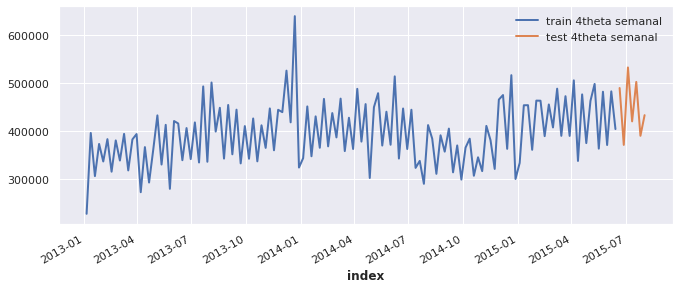

In [127]:
train_4theta_semanal, test_4theta_semanal = Ventas_totales_semanales_series.split_before(pd.Timestamp("2015-06-20")) 
train_4theta_semanal.plot(label="train 4theta semanal")
test_4theta_semanal.plot(label="test 4theta semanal")

In [128]:
fourtheta_model_semanal = FourTheta(seasonality_period = 52)
fourtheta_model_semanal.fit(train_4theta_semanal)
fourtheta_pred_semanal = fourtheta_model_semanal.predict(len(test_4theta_semanal))
print("model {} obtains MAPE: {:.2f}%".format(fourtheta_model_semanal, mape(test_4theta_semanal, fourtheta_pred_semanal)))

model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 10.54%


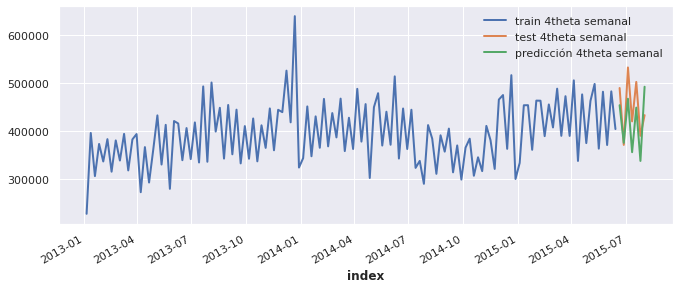

In [129]:
train_4theta_semanal.plot(label="train 4theta semanal")
test_4theta_semanal.plot(label="test 4theta semanal")
fourtheta_pred_semanal.plot(label="predicción 4theta semanal")

In [130]:
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
theta_grid = {
    #'theta':2- np.linspace(-10, 10, 10),
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}
best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=train_4theta_semanal,
                                forecast_horizon=6, 
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

(<darts.models.forecasting.theta.FourTheta at 0x7f2285636910>,
 {'theta': 1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 13.997911536072536)

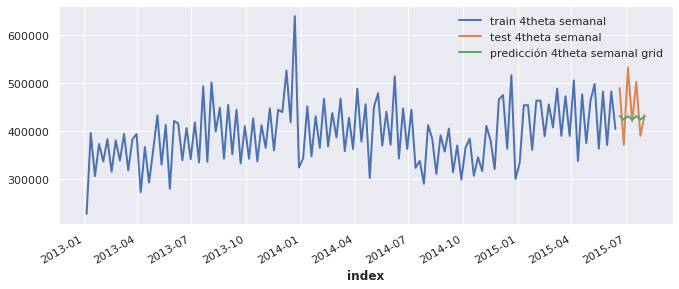

In [131]:
fourtheta_model_semanal_grid=FourTheta(theta=best_grid_model[1]['theta'],
                             model_mode=ModelMode.ADDITIVE,
                             season_mode=SeasonalityMode.MULTIPLICATIVE,
                             trend_mode=TrendMode.EXPONENTIAL)

fourtheta_model_semanal_grid.fit(train_4theta_semanal)
pred_modelo_4theta_grid = fourtheta_model_semanal_grid.predict(len(test_4theta_semanal))

train_4theta_semanal.plot(label="train 4theta semanal")
test_4theta_semanal.plot(label="test 4theta semanal")
pred_modelo_4theta_grid.plot(label="predicción 4theta semanal grid")

In [132]:
pred_modelo_4theta_grid

<TimeSeries (DataArray) (index: 7, component: 1, sample: 1)>
array([[[430646.10828591]],

       [[423064.84647669]],

       [[430646.10828591]],

       [[423064.84647669]],

       [[430646.10828591]],

       [[423064.84647669]],

       [[430646.10828591]]])
Coordinates:
  * index      (index) datetime64[ns] 2015-06-21 2015-06-28 ... 2015-08-02
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [133]:
Comparacion_4theta_semanal = pd.DataFrame()

Comparacion_4theta_semanal['Datos reales'] = y_test_semanal['Sales']
Comparacion_4theta_semanal['Predicciones'] = ['430646.1', '423064.84', '430646.1', '423064.84', '430646.1','423064.84']

Comparacion_4theta_semanal

,Datos reales,Predicciones
2015-06-28,370530,430646.1
2015-07-05,531819,423064.84
2015-07-12,419561,430646.1
2015-07-19,501709,423064.84
2015-07-26,389502,430646.1
2015-08-02,432467,423064.84


In [134]:
print("model {} obtains MAPE: {:.2f}%".format(fourtheta_model_semanal_grid, mape(test_4theta_semanal, pred_modelo_4theta_grid)))

model 4Theta(theta:1, curve:TrendMode.EXPONENTIAL, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 9.88%


In [135]:
#MAPE
MAPE_4theta_semanal = mape(test_4theta_semanal, pred_modelo_4theta_grid)
MAPE_4theta_semanal

9.881948373752696

### **9.4. TBATS**

In [138]:
Ventas_totales_semanales_series

<TimeSeries (DataArray) (index: 135, component: 1, sample: 1)>
array([[[227030.]],

       [[395390.]],

       [[305576.]],

       [[372581.]],

       [[335998.]],

       [[382548.]],

       [[314769.]],

       [[379940.]],

       [[337950.]],

       [[393446.]],

...

       [[370315.]],

       [[482018.]],

       [[403520.]],

       [[489005.]],

       [[370530.]],

       [[531819.]],

       [[419561.]],

       [[501709.]],

       [[389502.]],

       [[432467.]]])
Coordinates:
  * index      (index) datetime64[ns] 2013-01-06 2013-01-13 ... 2015-08-02
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

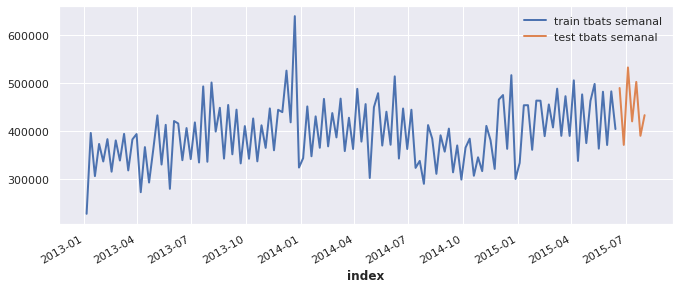

In [139]:
train_tbats_semanal, test_tbats_semanal = Ventas_totales_semanales_series.split_before(pd.Timestamp("2015-06-20")) 
train_tbats_semanal.plot(label="train tbats semanal")
test_tbats_semanal.plot(label="test tbats semanal")

In [140]:
model_TBATS_semanal = TBATS(
use_box_cox = None,
box_cox_bounds = (0, 1),
use_trend = None,
use_damped_trend = None,
seasonal_periods = "freq",
use_arma_errors = True,
show_warnings = False,
multiprocessing_start_method = 'spawn',
random_state = 0)
model_TBATS_semanal.fit(train_tbats_semanal)
TBATS_pred_semanal = model_TBATS_semanal.predict(len(test_tbats_semanal))
print("model {} obtains MAPE: {:.2f}%".format(model_TBATS_semanal, mape(test_tbats_semanal, TBATS_pred_semanal)))

model (T)BATS obtains MAPE: 9.13%


In [141]:
model_TBATS_semanal.model.params.summary()

'Use Box-Cox: False\nUse trend: False\nUse damped trend: False\nSeasonal periods: []\nSeasonal harmonics []\nARMA errors (p, q): (2, 0)\nSmoothing (Alpha): 0.188904\nSeasonal Parameters (Gamma): []\nAR coefficients [-0.39172253  0.16077235]\nMA coefficients []\nSeed vector [348876.52349001      0.              0.        ]\n'

In [142]:
TBATS_pred_semanal

<TimeSeries (DataArray) (index: 7, component: 1, sample: 1)>
array([[[450827.50406329]],

       [[419675.7806576 ]],

       [[439484.35133913]],

       [[426716.55202177]],

       [[434902.65720491]],

       [[429643.26622377]],

       [[433019.58756316]]])
Coordinates:
  * index      (index) datetime64[ns] 2015-06-21 2015-06-28 ... 2015-08-02
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [143]:
Comparacion_tbats_semanal = pd.DataFrame()

Comparacion_tbats_semanal['Datos reales'] = y_test_semanal['Sales']
Comparacion_tbats_semanal['Predicciones'] = ['450827.50', '439484.35', '426716.55', '434902.65', '429643.26','433019.58']

Comparacion_tbats_semanal

,Datos reales,Predicciones
2015-06-28,370530,450827.50
2015-07-05,531819,439484.35
2015-07-12,419561,426716.55
2015-07-19,501709,434902.65
2015-07-26,389502,429643.26
2015-08-02,432467,433019.58


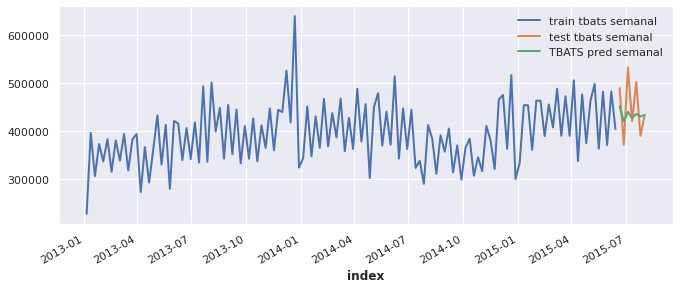

In [144]:
train_tbats_semanal.plot(label="train tbats semanal")
test_tbats_semanal.plot(label="test tbats semanal")
TBATS_pred_semanal.plot(label="TBATS pred semanal")

In [145]:
#MAPE
MAPE_TBATS_semanal = mape(test_tbats_semanal, TBATS_pred_semanal)
MAPE_TBATS_semanal

9.126810816576079

### **9.5. Comparación modelos semanales**

In [146]:
MAPE_modelos_semanales = pd.DataFrame()

MAPE_modelos_semanales['Modelos semanales'] = ["ETS", "ARIMA", "4THETA", "TBATS"]
MAPE_modelos_semanales['MAPE (%)'] = [MAPE_ETS_semanal, MAPE_ARIMA_semanal, MAPE_4theta_semanal, MAPE_TBATS_semanal]
MAPE_modelos_semanales.set_index('Modelos semanales', inplace = True)
MAPE_modelos_semanales = MAPE_modelos_semanales.sort_values(by = "MAPE (%)", ascending = True)

MAPE_modelos_semanales.round(3)

,MAPE (%)
Modelos semanales,
ARIMA,8.835
TBATS,9.127
4THETA,9.882
ETS,10.627


### **9.6. Predicción de las ventas totales semanales desde el 01.08.2015 hasta el 10.09.2015 con ARIMA**

In [147]:
fh_pred_def = np.arange(6) + 1  #6 semanas (las que hay desde 01.08.2015 hasta 10.09.2015)
fh_pred_def

array([1, 2, 3, 4, 5, 6])

In [149]:
ARIMA_model_semanal_def = AutoARIMA(sp = 52,suppress_warnings=True)
ARIMA_model_semanal_def.fit(log_df_semanal) #ahora sobre todos los datos, no solo sobre train

AutoARIMA(sp=52, suppress_warnings=True)

In [150]:
print(ARIMA_model_semanal_def.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 52)   Log Likelihood                  80.187
Date:                             Wed, 11 Jan 2023   AIC                           -150.373
Time:                                     12:04:02   BIC                           -135.884
Sample:                                 01-06-2013   HQIC                          -144.485
                                      - 08-02-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5744      0.073     -7.898      0.000      -0.717      -0.432
ma.L1         -0.6707      

In [151]:
ARIMA_pred_semanal_log_def = ARIMA_model_semanal_def.predict(fh_pred_def)
ARIMA_pred_semanal_log_def

,Sales
2015-08-09,13.073891
2015-08-16,12.938040
2015-08-23,12.988729
2015-08-30,13.009845
2015-09-06,12.991915
2015-09-13,12.973185


In [152]:
ARIMA_pred_semanal_def = np.exp(ARIMA_pred_semanal_log_def)
ARIMA_pred_semanal_def

,Sales
2015-08-09,476342.047510
2015-08-16,415833.356485
2015-08-23,437454.847370
2015-08-30,446790.420534
2015-09-06,438851.044851
2015-09-13,430707.605004


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot: >)

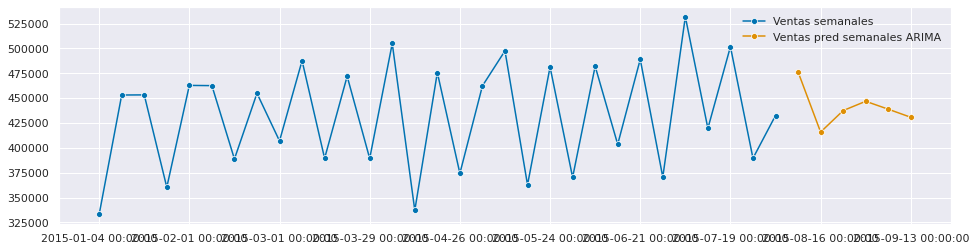

In [153]:
plot_series(Ventas_totales_semanales_pred['2015':], ARIMA_pred_semanal_def, labels=["Ventas semanales", "Ventas pred semanales ARIMA"])

In [ ]:
ARIMA_pred_semanal_def.to_csv('/content/drive/MyDrive/Análisis predictivo/Predicciones_semanales.csv', index=False)